In [38]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from collections import Counter
from IPython.display import display
from scipy import stats
from graphviz import Digraph
import graphviz
from sklearn.impute import SimpleImputer


# Load Dataset


In [39]:
df = pd.read_csv("train_ds.csv")

In [40]:
# Make a copy of the DataFrame to preserve the original
df_encoded = (df[:]).copy()

display(df_encoded)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,Aygo,2016.0,7500.0,Manual,14612.0,Petrol,0.0,69.0,1.0,toyota
1,Up,2018.0,8712.0,Manual,1607.0,Petrol,145.0,64.2,1.0,volkswagen
2,Focus,2018.0,12670.0,Manual,7162.0,Petrol,NaN,60.1,1.0,ford
3,GLA Class,2019.0,23599.0,Semi-Auto,NaN,Petrol,145.0,36.2,1.6,merc
4,Octavia,2019.0,18999.0,Semi-Auto,1162.0,Petrol,NaN,44.8,1.5,skoda
...,...,...,...,...,...,...,...,...,...,...
2395,Tiguan,2020.0,26980.0,Manual,2194.0,Diesel,145.0,42.2,NaN,volkswagen
2396,3 Series,2017.0,16000.0,Manual,34098.0,Diesel,145.0,64.2,2.0,BMW
2397,Fiesta,2018.0,NaN,Manual,NaN,Petrol,145.0,65.7,NaN,ford
2398,Up,2017.0,7391.0,Manual,NaN,Petrol,150.0,64.2,NaN,volkswagen


# Phase 2

## 2-1 Node and Desicion Tree class

In [41]:
class Node:

    def __init__(self, threshold=None, value=None, data=None, feature_idx=None, allowed_features_idxes=None,
                 entropy=None,
                 info_gain=None,
                 class_label=None, feature_names=None):
        self.value = value
        self.data = data
        self.feature_idx = feature_idx  #  Feature to make the split and branches
        self.allowed_features_idxes = allowed_features_idxes
        self.children = {}  #  Branches coming off the decision nodes(dict type)
        self.class_label = class_label  #  If it is a leaf Node
        self.entropy = entropy
        self.info_gain = info_gain
        self.threshold = threshold
        

    def get_label(self, record):
        if self.class_label is not None:
            return self.class_label

        value = record[self.feature_idx]

        if self.threshold is not None:
            # return self.children[0].get_label(record) if value <= self.threshold else self.children[1].get_label(record)
            child_idx = 0 if value <= self.threshold else 1
        else:
            if value in self.children.keys():
                child_idx = value
                # return self.children[value].get_label(record)
            else:
                return None
                # raise Exception(f"unknown value: {value} in feature: {self.feature_idx}")

        return self.children[child_idx].get_label(record)


    def print_node(self):
        if self.class_label is not None:
            return f"class_label = {self.class_label}"
        else:
            return f"split_feat= {self.value} \n feat_indices = {self.allowed_features_idxes} \n entropy = {self.entropy} \n info_gain = {self.info_gain}"


In [42]:
class DecisionTree:

    def __init__(self, all_labels, label_encoders, target_idx, initial_allowed_features, min_sample_in_leaf=1):
        self.all_labels = all_labels
        self.feature_names = initial_allowed_features
        self.min_sample_in_leaf = min_sample_in_leaf
        self.max_depth = 100
        self.root = None  # Initialize root node as None
        self.label_encoders = label_encoders
        self.target_idx = target_idx
        self.continuous_idxes = {2, 4, 6, 7, 8}
        self.categorical_idxes = {0, 1, 3, 5, 9}


    def to_dot(self) -> str:
        dot = Digraph()
        self._add_nodes(dot, self.root)
        return dot

    def _add_nodes(self, dot, node):
        if node is not None:
            
            dot.node(str(id(node)), label=node.print_node())

            if node.threshold is not None:
                # continuous feature
                threshold_str = f"<= {node.threshold}" if node.threshold is not None else ""

                dot.edge(str(id(node)), str(id(node.children[0])), label=threshold_str)
                self._add_nodes(dot, node.children[0])

                dot.edge(str(id(node)), str(id(node.children[1])), label=f"> {node.threshold}")
                self._add_nodes(dot, node.children[1])

            else:
                # categorical feature
                if hasattr(self, 'label_encoders') and node.feature_idx in self.categorical_idxes:
                    encoder = self.label_encoders[self.feature_names[node.feature_idx]]
                    feature_values = encoder.inverse_transform(np.unique(node.data[:, node.feature_idx]).astype(int))
                else:
                    feature_values = np.unique(node.data[:, node.feature_idx])

                for i, child in enumerate(node.children.values()):

                    dot.edge(str(id(node)), str(id(child)), label=str(feature_values[i]))
                    self._add_nodes(dot, child)


    def _print_data(self, data: np.ndarray):
        try:
            decoded_df = pd.DataFrame(data, columns=self.feature_names)
        except Exception as error:
            print(f"Error:{error}")
            print(self.feature_names)
            print(data)

        for col in self.feature_names:
            if col in self.label_encoders:
                decoded_df[col] = self.label_encoders[col].inverse_transform(decoded_df[col].astype(int))

        display(decoded_df)

    def test(self, data: np.ndarray):
        if self.root is None:
            return None

        total_records = len(data)
        correct_labels = 0

        labels = []

        self._print_data(data)
        for row in data:
            label = self.root.get_label(row)

            if label is not None:  # got label
                labels.append(label)

                if label == row[self.target_idx]:
                    correct_labels = correct_labels + 1
            else:
                pass
                # raise Exception("None label")

        print(f"accuracy: {correct_labels / total_records}")

        valid_labels = []
        for label in labels:
            if not np.isnan(label):
                valid_labels.append(label)

        labels = np.array(valid_labels)
        
        decoded_label = self.label_encoders['model'].inverse_transform(labels.astype(int))

        return decoded_label

    def _get_entropy(self, labels):
        elements, counts = np.unique(labels, return_counts=True)
        entropy = np.sum(
            [(-counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))])
        return entropy

    def _subset_entropy(self, subsets: list):
        """
        Returns:
          Weigthed sum child entropies
        """
        sum_labels = sum([len(subset) for subset in subsets])

        return sum([self._get_entropy(labels=subset) *
                    (len(subset) / sum_labels) for subset in subsets])

    def _get_info_gain(self, data: np.array, feature_idx, target_idx=0):
        total_entropy = self._get_entropy(labels=data[:, target_idx])
        weighted_entropy = total_entropy
        threshold = None

        if feature_idx in self.categorical_idxes:
            feature_values, value_counts = np.unique(data[:, feature_idx], return_counts=True)

            weighted_entropy = np.sum([(value_counts[i] / np.sum(value_counts)) *
                                       self._get_entropy(
                                           labels=data[np.where(data[:, feature_idx] == feature_values[i])][:,
                                                  target_idx])
                                       for i in range(len(feature_values))])

        elif feature_idx in self.continuous_idxes:
            threshold = self.get_best_threshold(data, feature_idx, target_idx)
            mask = data[:, feature_idx] < threshold
            left_data = data[mask]
            right_data = data[~mask]

            weighted_entropy = (self._get_entropy(labels=left_data[:, target_idx]) * left_data.shape[0] +
                                self._get_entropy(labels=right_data[:, target_idx]) * right_data.shape[0]) / (
                                       left_data.shape[0] + right_data.shape[0])

        information_gain = total_entropy - weighted_entropy

        return information_gain, threshold

    def get_best_threshold(self, data: np.array, feature_idx, target_idx=0):
        best_threshold = None
        minimum_weighted_entropy = float('inf')

        sort_feature_data = sorted(data[:, feature_idx])

        for i in range(len(sort_feature_data) - 1):
            threshold = (sort_feature_data[i] + sort_feature_data[i + 1]) / 2

            g1, g2 = self._split_data(data=data, feature_idx=feature_idx, feature_vals=threshold)

            subset_entropy = self._subset_entropy([g1[:, 0], g2[:, 0]])

            if subset_entropy < minimum_weighted_entropy:
                minimum_weighted_entropy = subset_entropy
                best_threshold = threshold

        return best_threshold

    def _choose_best_feature(self, data: np.array, allowed_features_idxes):
        """
        This function is for finding the best feature to split for categorical features
        """

        best_info_gain = -1
        best_feature_idx = -1
        best_thresh = None

        if allowed_features_idxes is None:
            raise Exception("what the fuck")
        for feature_idx in allowed_features_idxes:
            if feature_idx != self.target_idx:
                info_gain, thresh = self._get_info_gain(data=data, feature_idx=feature_idx)
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_thresh = thresh

        return best_feature_idx, best_info_gain, best_thresh

    def _split_data(self, data: np.array, feature_idx, feature_vals):
        """
        Split data according to a feature index and a value.
        """
        split_data_groups = []
        if isinstance(feature_vals, (list, np.ndarray)):
            # if feature is categorical
            for val in feature_vals:
                mask = data[:, feature_idx] == val
                split_data_groups.append(data[mask])

        elif isinstance(feature_vals, float):
            # if feature is continuous
            mask = data[:, feature_idx] < feature_vals
            split_data_groups.append(data[mask])
            split_data_groups.append(data[~mask])

        return split_data_groups

    def _best_feat_split(self, data: np.array, allowed_features_idxes):
        if allowed_features_idxes is None:
            raise Exception("what the fuck split")
        best_feature_idx, best_info_gain, best_thresh = self._choose_best_feature(data=data,
                                                                                  allowed_features_idxes=allowed_features_idxes)
        if best_thresh is not None:
            split_data_groups = self._split_data(data=data, feature_idx=best_feature_idx,
                                                 feature_vals=best_thresh)
        else:
            split_data_groups = self._split_data(data=data, feature_idx=best_feature_idx,
                                                 feature_vals=np.unique(data[:, best_feature_idx]))

        return split_data_groups, best_feature_idx, best_info_gain, best_thresh

    def _build_tree_recursive(self, data: np.array, current_depth: int, allowed_features_idxes):
        if current_depth > self.max_depth:
            return None

        if len(np.unique(data[:, self.target_idx])) == 1:
            # pure Node
            return Node(data=data, class_label=data[0, self.target_idx])

        if current_depth == self.max_depth:
            node = Node(data=data, class_label=data[:, self.target_idx])

        if allowed_features_idxes is None:
            raise Exception("what the fuck build")

        split_data_groups, best_feature_idx, best_info_gain, best_thresh = self._best_feat_split(data=data,
                                                                                                 allowed_features_idxes=allowed_features_idxes)

        if best_feature_idx == -1:
            return Node(data=data, class_label=stats.mode(data[:, self.target_idx])[0])

        node_entropy = self._get_entropy(labels=data[:, self.target_idx])

        node = Node(data=data, value=self.feature_names[best_feature_idx], feature_idx=best_feature_idx,
                     allowed_features_idxes=allowed_features_idxes, entropy=node_entropy,
                    info_gain=best_info_gain, threshold=best_thresh)

        new_allowed_features_idxes = allowed_features_idxes.copy()
        new_allowed_features_idxes.remove(best_feature_idx)
        for i, data_group in enumerate(split_data_groups):
            if self.min_sample_in_leaf > data_group.shape[1] or best_info_gain <= 0:
                node = Node(data=data, class_label=stats.mode(data[:, self.target_idx])[0])
                return node

            if best_feature_idx in self.categorical_idxes:
                index = data_group[:, best_feature_idx][0]
                node.children[index] = self._build_tree_recursive(data=data_group, current_depth=current_depth + 1,
                                                                  allowed_features_idxes=new_allowed_features_idxes)

            elif best_feature_idx in self.continuous_idxes:
                node.children[i] = self._build_tree_recursive(data=data_group, current_depth=current_depth + 1,
                                                              allowed_features_idxes=new_allowed_features_idxes)
            else:
                raise Exception("wrong feature_idx")

        return node

    def create_tree(self, data: np.array, allowed_features_idxes: list):
        """Builds the decision tree from the given data and feature names.

        Args:
          data: The training data (numpy array).
          allowed_features_idxes: List of feature names corresponding to data columns.

        Returns:
          The root node of the decision tree.
        """
        self.root = self._build_tree_recursive(data=data, current_depth=0,
                                               allowed_features_idxes=allowed_features_idxes)
        return self.root

    def print_tree(self, feature_names):
        """Prints the decision tree structure in text format."""
        if self.root:
            print("Decision Tree:")
            self._print_tree_helper(node=self.root, depth=0, feature_names=feature_names)
        else:
            print("No decision tree built yet.")

    def _print_tree_helper(self, node, depth, feature_names):
        if not node:
            return

        indent = "  " * depth

        # Decode class label if it's encoded
        decoded_class_label = None
        if node.class_label is not None:
            if hasattr(self, 'label_encoders'):  # Check for encoder
                class_label_encoder = self.label_encoders[feature_names[self.target_idx]]
                try:
                    decoded_class_label = class_label_encoder.inverse_transform([node.class_label.astype(int)])
                except Exception as error:
                    print("An exception occurred:", error)
            else:
                decoded_class_label = node.class_label  # No decoding if encoder not found
        else:
            decoded_class_label = None

        leaf_label = f"Class: {decoded_class_label}" if decoded_class_label is not None else "SPLIT"

        if node.feature_idx is not None:
            feature_name = feature_names[node.feature_idx]
            if feature_name in self.label_encoders:
                encoder = self.label_encoders[feature_name]
                display(np.unique(node.data[:, node.feature_idx]).astype(int))
                unique_values = encoder.inverse_transform(np.unique(node.data[:, node.feature_idx]).astype(int))

            else:
                unique_values = np.unique(node.data[:, node.feature_idx])


            print(f"{indent}{feature_name} in ({', '.join(unique_values.astype(str))})?")
            for child, value in zip(node.children.values(), unique_values):
                print(f"{indent + '|'}   {value}:")
                self._print_tree_helper(node=child, depth=depth + 1, feature_names=feature_names)
        else:
            print(f"{indent}{leaf_label}")



## 2-2 Phase 1 filling missing 

### 2-2-1 Drop missing values

In [64]:
newdf = (df[:]).copy()

# Encode categorical columns using label encoding
categorical_cols = ['model', 'year', 'transmission', 'fuelType', 'Manufacturer']

newdf.dropna(inplace=True)

display(newdf)

label_encoder_dict = {}

for col in categorical_cols:
    label_encoder_dict[col] = LabelEncoder()
    newdf[col] = label_encoder_dict[col].fit_transform(newdf[col])


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,Aygo,2016.0,7500.0,Manual,14612.0,Petrol,0.0,69.0,1.0,toyota
1,Up,2018.0,8712.0,Manual,1607.0,Petrol,145.0,64.2,1.0,volkswagen
7,Yaris,2017.0,9991.0,Manual,2781.0,Petrol,150.0,58.9,1.5,toyota
11,Mokka X,2017.0,13295.0,Manual,9326.0,Petrol,145.0,42.2,1.6,vauxhall
12,X1,2015.0,8995.0,Manual,90000.0,Diesel,160.0,51.4,2.0,BMW
...,...,...,...,...,...,...,...,...,...,...
2379,Polo,2009.0,2495.0,Manual,41637.0,Petrol,145.0,48.7,1.2,volkswagen
2383,Q2,2017.0,27999.0,Semi-Auto,24450.0,Petrol,145.0,51.4,1.4,Audi
2386,EcoSport,2016.0,10484.0,Semi-Auto,19961.0,Petrol,160.0,44.8,1.5,ford
2393,Up,2016.0,6990.0,Manual,10876.0,Petrol,20.0,64.2,1.0,volkswagen


### 2-2-2 Filling missing with Mode

In [60]:

newdf = (df[:]).copy()

# Encode categorical columns using label encoding
categorical_cols = ['model', 'year', 'transmission', 'fuelType', 'Manufacturer']

label_encoder_dict = {}


for col in categorical_cols:
    label_encoder_dict[col] = LabelEncoder()
    newdf[col] = label_encoder_dict[col].fit_transform(newdf[col])

imputer = SimpleImputer(strategy='most_frequent')

newdf[newdf.columns] = imputer.fit_transform(newdf[newdf.columns])



### 2-2-3 Filling missing values with mode and mean

In [15]:

newdf = (df[:]).copy()

# Encode categorical columns using label encoding
categorical_cols = ['model', 'year', 'transmission', 'fuelType', 'Manufacturer']

label_encoder_dict = {}


for col in categorical_cols:
    label_encoder_dict[col] = LabelEncoder()
    newdf[col] = label_encoder_dict[col].fit_transform(newdf[col])

imputer = SimpleImputer(strategy='most_frequent')

newdf[categorical_cols] = imputer.fit_transform(newdf[categorical_cols])

imputer1 = SimpleImputer(strategy='mean')

continuous_cols = ['price', 'mileage', 'tax', 'mpg', 'engineSize']
newdf[continuous_cols] = imputer1.fit_transform(newdf[continuous_cols])



## 2-3 Fit model

In [65]:
feature_names = list(newdf.keys())

dt = DecisionTree(np.unique(newdf['model']), label_encoders=label_encoder_dict, initial_allowed_features=feature_names,
                  target_idx=0)

data = np.array(newdf)

x = list(range(len(newdf.columns)))

root = dt.create_tree(data=data, allowed_features_idxes=x)


In [68]:
dot_data = dt.to_dot()

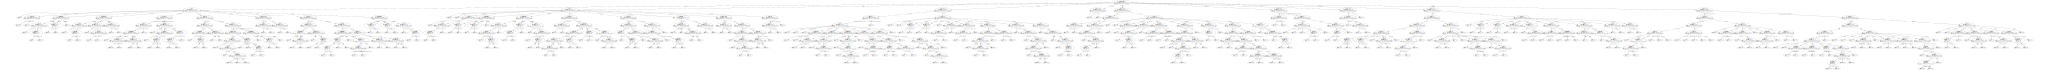

In [69]:
dot_data

In [70]:
# Render the DOT file to an image (e.g., tree.png)
graph = graphviz.Source(dot_data.source)

graph.format = "png"
graph.render('tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.62245 to fit


'tree.png'

## 2-4 Predict test_data


In [71]:
test_data = pd.read_csv("test_ds.csv")
for col in categorical_cols:
    test_data[col] = label_encoder_dict[col].fit_transform(test_data[col])
# test_data.info()

labels = dt.test(data=np.array(test_data))
labels

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,C Class,2016,17950.0,Automatic,20005.0,Diesel,30.0,64.2,2.1,merc
1,2 Series,2019,24590.0,Semi-Auto,3300.0,Diesel,145.0,48.7,2.0,BMW
2,Fabia,2018,9981.0,Manual,5895.0,Petrol,145.0,64.2,1.0,skoda
3,X1,2017,19371.0,Semi-Auto,21293.0,Diesel,150.0,60.1,2.0,BMW
4,Fiesta,2016,7999.0,Manual,60730.0,Diesel,0.0,78.5,1.5,ford
...,...,...,...,...,...,...,...,...,...,...
595,3 Series,2015,15491.0,Automatic,35248.0,Diesel,30.0,64.2,2.0,BMW
596,E Class,2017,20980.0,Semi-Auto,32106.0,Diesel,145.0,65.7,2.0,merc
597,1 Series,2016,13491.0,Manual,24000.0,Diesel,30.0,65.7,2.0,BMW
598,Fiesta,2017,8495.0,Manual,33000.0,Petrol,125.0,54.3,1.2,ford


accuracy: 0.5416666666666666


array([' C Class', ' Fabia', ' Fiesta', ' Q3', ' Fiesta', ' Corsa',
       ' Tiguan', ' Mokka X', ' 3 Series', ' Tiguan', ' X1', ' A1', ' A3',
       ' Fiesta', ' 2 Series', ' I10', ' Polo', ' Insignia', ' Mokka X',
       ' GLC Class', ' A3', ' Aygo', ' EcoSport', ' Golf', ' Mokka X',
       ' Corsa', ' Fiesta', ' Golf', ' Fiesta', ' A Class', ' Fabia',
       ' A3', ' Corsa', ' Fiesta', ' Golf', ' Aygo', ' Mokka', ' Aygo',
       ' Golf', ' Fiesta', ' Up', ' A3', ' Polo', ' Up', ' Golf',
       ' EcoSport', ' Aygo', ' A5', ' Yaris', ' Golf', ' E Class',
       ' Corsa', ' EcoSport', ' Q3', ' EcoSport', ' Fiesta', ' 2 Series',
       ' A5', ' Golf', ' Golf', ' C Class', ' Tiguan', ' Tucson', ' Up',
       ' Fabia', ' X1', ' 1 Series', ' Focus', ' Kuga', ' 1 Series',
       ' Golf', ' X1', ' Golf', ' Kuga', ' Astra', ' C Class', ' I10',
       ' Q3', ' Yaris', ' Corsa', ' Golf', ' A3', ' Q2', ' A1',
       ' A Class', ' Polo', ' C Class', ' Fabia', ' C Class', ' Kuga',
       ' EcoSpor